In [1]:
#Libraries for math and data manipulation
import numpy as np
import pandas as pd
import math
import numpy.random as rand
import scipy as sp
import sys
from datetime import datetime

import ellipses as el
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.spatial import ConvexHull

#Plotting stuff
import matplotlib.pyplot as plt
import seaborn
import corner
%matplotlib inline
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True) #Want to be able to use tex in the plot labels
seaborn.set_style('ticks')
seaborn.set_color_codes()


In [2]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

In [3]:
data_pd = pd.read_csv('../Sims/test/cases_vaxvar0.25_popvar0.01_pop100000.0_0.csv',\
                      delim_whitespace=True,header=0)

In [ ]:
#Normalization stuff.
#It *does* need to happen if you're using the area as the metric. Also, using the maximum in each year starting
#at January doesn't work - because the peak is different at different times. Amalies uses the maximum within a one
#year sliding window, so maybe that's better?

Idata = data_pd.values.copy()
Idata_norm = np.zeros(shape=np.shape(Idata))
nobs = len(Idata)      #How many 'observations'? (i.e. timesteps)
dates = np.linspace(0,nobs-1,nobs) 
dates = (dates)%24     #A year is 24 timesteps, in this code. For whatever reason.
theta = 2.*np.pi*((dates+1)/24.)

print dates

In [152]:
def Normalize(data):
    nobs = len(data)      #How many 'observations'? (i.e. timesteps)
    dates = np.linspace(0,nobs-1,nobs) 
    dates = (dates)%24     #A year is 24 timesteps, in this code. For whatever reason.
    theta = 2.*np.pi*((dates+1)/24.)
    npatch = np.shape(data)[1]  
    data_norm = np.zeros([nobs,npatch])
    for p in range(npatch):
        nhigh = 0
        '''
        #This loop goes through each *calendar year* and finds the maximum number of individuals.
        maxI = []
        i = 0
        j = 0
        for d in dates:
            if d ==0:
                nhigh = 0
            else:
                if Idata[i,p] > nhigh:
                    nhigh = Idata[i,p]
            if d ==23:
                maxI.append(nhigh)
            i += 1
        '''
        k = 0
        for d in dates:
            #This loop looks forward/backward 12 timesteps and finds the maximum in that window.
            if k<12:
                nhigh = np.max(data[0:k+12,p])
            elif k>1200-12:
                nhigh = np.max(data[k-12:,p])
            else:
                nhigh = np.max(data[k-12:k+12,p])    
            if nhigh==0.:
                nhigh += 1.5      #Don't divide by zero.
            data_norm[k,p] = data[k,p]/float(nhigh)
            if nhigh==1.:   #Only one infection in this window - i.e. probably just a virgin intro. burst
                data_norm[k,p] = 0.
            k += 1
    return data_norm

def AreaCalc(data,tstart=800):
    npatch = np.shape(data)[1] 
    area = []
    for i in range(npatch):
        thetafit = theta[tstart:]
        Ifit = data[tstart:,i]
        cartcoords = pol2cart(Ifit,thetafit)
        points = np.array(cartcoords)
        points = points.T
        if len(data)>1:
            hull = ConvexHull(points)
            area.append(hull.volume)
    return area

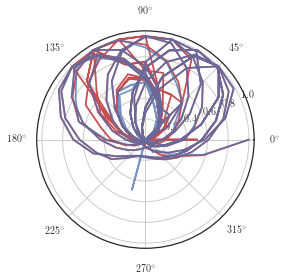

In [153]:
tstart = 500
#plt.polar(theta[tstart:],Idata_norm[istart:,190]);
plt.polar(theta[tstart:],Idata_norm[tstart:,90],color='r');
plt.polar(theta[tstart:],Idata_norm[tstart:,91],alpha=0.75)


In [154]:
#Check that random noise gives you a large area, and a sinusoid gives you a small area:

In [170]:
Stochtest = np.random.normal(loc=0,scale=3,size=[1200,100])*10.
Stochtest[Stochtest<0.] = 0.
sinrange = np.linspace(0,1200-1,1200)
Sintest = np.abs(np.cos(sinrange*2.*np.pi/48.+6.)**8)*5.
Sintest = Sintest.reshape([1200,1])

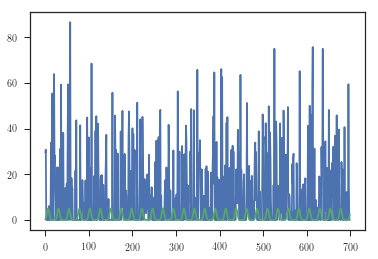

In [172]:
plt.plot(Stochtest[500:,4])
plt.plot(Sintest[500:])

In [173]:
stoch_norm = Normalize(Stochtest)
sin_norm = Normalize(Sintest)

In [174]:
area_stoch = AreaCalc(stoch_norm)
area_sin = AreaCalc(sin_norm)

[2.988187750241592, 2.7188322449151, 2.9308746671853774, 2.8977267224433607, 3.0358771837596588, 2.8262893770979667, 2.9211879480740652, 2.7644310142177795, 2.9041279581584893, 2.837924529393819, 2.9846308577130007, 2.8702798762270283, 2.8959125915052533, 2.9703904338552456, 2.9459289615245168, 2.9352539422734107, 2.9471716475032776, 2.9386325607560333, 2.766817450687036, 2.9841582588285287, 2.8448732374555377, 2.849267983474264, 2.9292811308884663, 2.846571564016383, 2.844011211075103, 2.821620492361234, 3.002907490676578, 2.915697897818226, 2.973140714138915, 2.869568722193114, 2.992382961596631, 2.9072340551353917, 2.8700618674532867, 2.7416723915348222, 2.9208332072100047, 2.5872107472887613, 2.8534529749475213, 2.8315524698149193, 2.844285753001048, 3.0133186449314566, 2.9948469904292065, 2.9009763883582287, 3.01466267843622, 2.964010350204278, 2.962562574046362, 2.8843372031758343, 2.9220660607076936, 2.807584426236361, 2.933607715798977, 2.952113730739926, 3.022921383000879, 2.9

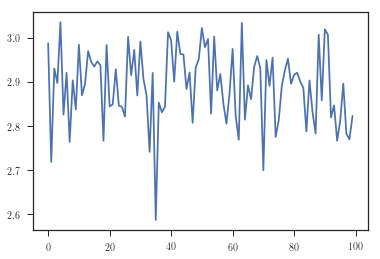

In [175]:
print area_stoch, area_sin
plt.plot(area_stoch)

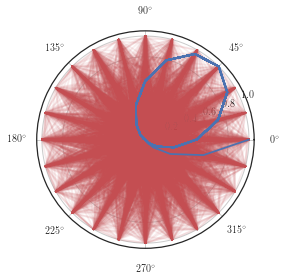

In [176]:
plt.polar(theta[tstart:],stoch_norm[tstart:],color='r',alpha=0.1);
plt.polar(theta[tstart:],sin_norm[tstart:],alpha=1.)

In [169]:
print np.pi/2.

1.57079632679
